Project 2

Start date: March 4 2025

Machine learning experiments

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from lazypredict.Supervised import LazyClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid

In [47]:
seed = random.randint(1000, 9999)
#seed = 3543 #2851 # 
np.random.seed(seed)
random.seed(seed)
print(seed)

1875


In [43]:
## Load data
df = pd.read_csv('data/term-deposit-marketing-2020.csv')

In [ ]:
df.head(2)

### Model 1

In [44]:
# Select demographic and financial fields
df_model1 = df.copy()
df_model1 = df.drop(columns=["contact", "day", "month", "duration", "campaign"])

# Apply Label Encoding to binary categorical features
binary_features = ["default", "housing", "loan", "y"]
label_encoders = {}
for col in binary_features:
    label_encoders[col] = LabelEncoder()
    df_model1[col] = label_encoders[col].fit_transform(df_model1[col])

# Apply One-Hot Encoding to multi-class categorical features
multi_class_features = ["job", "marital", "education"]
df_model1 = pd.get_dummies(df_model1, columns=multi_class_features, drop_first=True)

# Display the transformed dataset
df_model1.head()

,age,default,balance,housing,loan,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,58,0,2143,1,0,0,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
1,44,0,29,1,0,0,False,False,False,False,...,False,False,True,False,False,False,True,True,False,False
2,33,0,2,1,1,0,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
3,47,0,1506,1,0,0,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,33,0,1,0,0,0,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True


In [58]:
# Separate features and target variable
X = df_model1.drop(columns=["y"])
y = df_model1["y"]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Numerical features for scaling
numerical_features = ["age", "balance"]

# Apply Standard Scaling to numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Display the prepared training set
#X_train.head(3), y_train.head(3)

print('x_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)


x_train shape:  (32000, 21)
y_train shape:  (32000,)
x_test shape:  (8000, 21)
y_test shape:  (8000,)


In [ ]:
# ## Running LazyPredict multiple times to assess stability of the models
# # Number of iterations
# num_iterations = 50

# # Dictionary to store top 10 models per iteration
# top_models_per_iteration = []

# # Dictionary to store best accuracy and corresponding seed for each model
# best_seeds = defaultdict(lambda: (0, None))

# for _ in range(num_iterations):
#     # Split data with different random seed
#     seed = random.randint(1000, 9999)
#     x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
#     # Initialize LazyClassifier
#     clf = LazyClassifier(verbose=0, predictions=False,ignore_warnings=True, custom_metric=recall_score,)
    
#     # Fit and evaluate models
#     models, _ = clf.fit(x_train, x_test, y_train, y_test)
    
#     # Get top 10 models for this iteration
#     top_10_models = models.head(5).index.tolist()
#     top_models_per_iteration.extend(top_10_models)
    
#     # Record best accuracy and corresponding seed
#     for model_name, row in models.iterrows():
#         accuracy = row['recall_score']
#         if accuracy > best_seeds[model_name][0]:
#             best_seeds[model_name] = (accuracy, seed)

# # Count occurrences of each model in the top 10
# model_counts = Counter(top_models_per_iteration)

# # Get the three most frequently appearing models
# best_models = model_counts.most_common(3)

# # Display results
# print("Top 3 Most Frequently Appearing Models in Top 5:")
# for model, count in best_models:
#     best_accuracy, best_seed = best_seeds[model]
#     print(f"{model}: {count} times, Best Accuracy: {best_accuracy:.4f}, Best Seed: {best_seed}")


In [49]:
clf = LazyClassifier(verbose=-1,ignore_warnings=True, predictions=True, random_state=seed, custom_metric=recall_score)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models

[('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>), ('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>), ('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>), ('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>), ('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>), ('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>), ('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>), ('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>), ('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>), ('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>), ('KNeighborsClassifier', <class 'sklearn.neighbors._classification.KNeighborsClassifier'>), ('LabelPropagation', <class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>), ('LabelSpreading', <class 'sklearn.semi_supervised._label_propagation.LabelSp

100%|██████████| 29/29 [00:59<00:00,  2.04s/it]

[LightGBM] [Info] Number of positive: 2317, number of negative: 29683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072406 -> initscore=-2.550301
[LightGBM] [Info] Start training from score -2.550301


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_score,Time Taken
Model,,,,,,
NearestCentroid,0.61,0.55,0.55,0.70,0.47,0.04
ExtraTreesClassifier,0.89,0.54,0.54,0.88,0.13,2.49
RandomForestClassifier,0.90,0.54,0.54,0.89,0.12,4.24
ExtraTreeClassifier,0.88,0.54,0.54,0.88,0.13,0.05
DecisionTreeClassifier,0.88,0.54,0.54,0.88,0.13,0.13
BaggingClassifier,0.91,0.53,0.53,0.89,0.09,0.78
KNeighborsClassifier,0.92,0.51,0.51,0.89,0.03,0.67
XGBClassifier,0.93,0.51,0.51,0.90,0.02,0.20
LGBMClassifier,0.93,0.51,0.51,0.89,0.01,0.21


In [ ]:
def display_results(model, model_name, X_train, y_train, X_test, y_test):
    
   # model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    metrics = []
    metrics.append([accuracy, recall, precision])

    plt.figure(figsize=(3, 3))
    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(model_name)

    metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
    print(metrics_df)
    plt.show()

   Accuracy  Recall  Precision
0      0.61    0.62       0.94
1      0.91    0.98       0.93
2      0.93    1.00       0.93


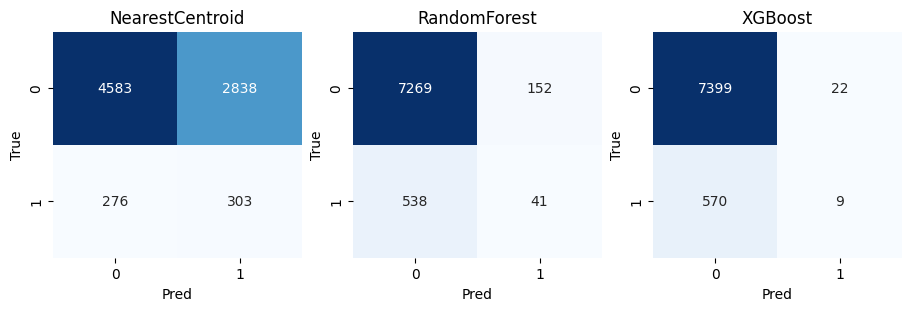

In [ ]:
# Re-training the selected models to evaluate consistency with LazyPredict results

classifiers = {
    'NearestCentroid': NearestCentroid(),
    'RandomForest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed)
}


fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)

metrics = []
importances = []

for idx, (clf_name, clf) in enumerate(classifiers.items()):

    model = clf

    model.fit(X_train, y_train) #clf.fit(x_train, y_train, eval_set=[(x_test, y_test)]) #(eval_set for early stopping)

    #display_results(model, clf_name, X_train, y_train, X_test, y_test)

    # Make predictions
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred,normalize=True)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    metrics.append([accuracy, recall, precision])

    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, fmt='g', cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])

print(metrics_df)
plt.show()